# Compare the precision of $R_{ZZ}(\phi) = \exp(-i \frac{\phi}{2} Z Z)$ at low $\phi$

Experiment:
Run $R_{ZZ}(\phi)$ for $0 < \phi < \frac{\pi}{2}$ (40 points). For each point, do a full process tomography.

- CNOT-based implementation
- Implementation in 2105.01063
- Linearized implementation

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pprint

from qiskit import pulse, QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, IBMQ
from qiskit.circuit import Gate, Parameter
from qiskit.circuit.barrier import Barrier
from qiskit import schedule as build_schedule
from qiskit.ignis.verification.tomography import process_tomography_circuits
from qiskit.tools.monitor import job_monitor
from qiskit.visualization.pulse_v2 import IQXDebugging

from pulse_experiment_utils import *

IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
#provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='q-comp-training')
provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='icepp')
backend = provider.get_backend('ibm_kawasaki')
#backend = provider.get_backend('ibmq_montreal')
#backend = provider.get_backend('ibmq_bogota')
#backend = provider.get_backend('ibmq_toronto')

In [3]:
control_qubit = 12
target_qubit = 13
li_correction_parameters = (-0.06197974  0.04280589)

backend_config = backend.configuration()
backend_defaults = backend.defaults()
dt = backend_config.dt
calibrations = backend_defaults.instruction_schedule_map

control_drive_channel = backend_config.drive(control_qubit)
target_drive_channel = backend_config.drive(target_qubit)
control_channel = backend_config.control((control_qubit, target_qubit))[0]

In [4]:
control_x_pulse = calibrations.get('x', [control_qubit]).instructions[0][1].pulse
target_x_pulse = calibrations.get('x', [target_qubit]).instructions[0][1].pulse
control_sx_pulse = calibrations.get('sx', [control_qubit]).instructions[0][1].pulse
target_sx_pulse = calibrations.get('sx', [target_qubit]).instructions[0][1].pulse
cx_sched = calibrations.get('cx', [control_qubit, target_qubit])
cr45_rotary_pulse = next(inst[1].pulse for inst in cx_sched.instructions if inst[1].name == 'CR90p_d{}_u{}'.format(target_drive_channel.index, control_channel.index))
cr45_pulse = next(inst[1].pulse for inst in cx_sched.instructions if inst[1].name == 'CR90p_u{}'.format(control_channel.index))

In [5]:
#phi_values = np.concatenate((np.linspace(0., np.pi / 6., 20, endpoint=False), np.linspace(np.pi / 6., np.pi, 10)))
#phi_values = np.linspace(np.pi / 6., np.pi * 14. / 54., 6, endpoint=False)
#phi_values = np.linspace(0., np.pi / 6., 5, endpoint=False)
#phi_values = phi_values[1:]
#phi_values = np.linspace(0.52359878, 0.57208014, 5, endpoint=False)[1:]
phi_values = np.concatenate((np.linspace(0., np.pi / 6., 20, endpoint=False), np.linspace(np.pi / 6., np.pi * 14. / 54., 6, endpoint=False), np.linspace(np.pi * 14. / 54., np.pi, 9)))
#example_index = (17, 60) # 17 is just random, 60 = ((Zm, Xp), (Z, X)) -> validates full gate cancellation (X of ctrl and H & H of target)
example_index = (2, 60)
#phi_values = np.array([0.1, 0.44, np.pi / 2.])
#example_index = (0, 60)

In [6]:
register = QuantumRegister(2)

In [7]:
#experiments = ['cx', 'pe', 'li']
experiments = ['li']
#experiments = ['pe', 'li']
#experiments = ['pe']
circuit_lists = dict()

## CNOT-based $R_{ZZ}$
### Template circuit

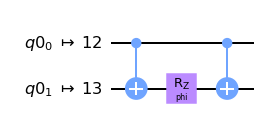

In [8]:
phi = Parameter('phi')
param_circuit = QuantumCircuit(register)
param_circuit.cx(0, 1)
param_circuit.rz(phi, 1)
param_circuit.cx(0, 1)

transpile(param_circuit, backend=backend, initial_layout=[control_qubit, target_qubit]).draw('mpl', idle_wires=False)

### Circuit generator

In [9]:
def cx_based_circuit(phi_value):
    return param_circuit.assign_parameters({phi: phi_value}, inplace=False)

### Circuits to run

In [10]:
if 'cx' in experiments:
    circuit_lists['cx'] = []
    for phi_value in phi_values:
        circuits = process_tomography_circuits(cx_based_circuit(phi_value), register)
        circuit_lists['cx'].append(transpile(circuits, backend=backend, initial_layout=[control_qubit, target_qubit]))
    
    circuit = circuit_lists['cx'][example_index[0]][example_index[1]]
    print(circuit.name)
    circuit.draw('mpl', idle_wires=False)

## $R_{ZZ}$ from 2105.01063 (Pulse-efficient circuit transpilation)

In [11]:
cr = cr45_pulse
crr = cr45_rotary_pulse
sigma = cr.sigma
tail = (cr.duration - cr.width) // 2

### Circuit generator

In [12]:
normal_tail_integral = np.sqrt(np.pi / 2.) * sigma * scipy.special.erf(tail / np.sqrt(2.) / sigma)
pedestal = np.exp(-0.5 * np.square(tail / sigma))
grounded_tail_integral = (normal_tail_integral - pedestal * tail) / (1. - pedestal)
tail_area = np.abs(cr.amp) * grounded_tail_integral
cr45_area_norm = np.abs(cr.amp) * cr.width + 2. * tail_area
minimum_phi = 2. * np.pi / 4. * (2. * tail_area) / cr45_area_norm

def pulse_efficient_circuit(phi_value, with_schedule=False):
    if phi_value == 0.:
        circuit = QuantumCircuit(register)

        if with_schedule:
            return circuit, pulse.Schedule(name='cr_gate_core')
        else:
            return circuit

    phi_label = np.round(phi_value / np.pi * 180.)
    if phi_value <= minimum_phi:
        amp_ratio = phi_value / minimum_phi
        duration = 2 * tail
        cr_pulse = pulse.Gaussian(duration=duration, amp=(amp_ratio * cr.amp), sigma=sigma, name='CR{}p_u{}'.format(phi_label, control_channel.index))
        cr_rotary_pulse = pulse.Gaussian(duration=duration, amp=(amp_ratio * crr.amp), sigma=sigma, name='CR{}p_d{}_u{}'.format(phi_label, target_drive_channel.index, control_channel.index))
        cr_echo = pulse.Gaussian(duration=duration, amp=-(amp_ratio * cr.amp), sigma=sigma, name='CR{}m_u{}'.format(phi_label, control_channel.index))
        cr_rotary_echo = pulse.Gaussian(duration=duration, amp=-(amp_ratio * crr.amp), sigma=sigma, name='CR{}m_d{}_u{}'.format(phi_label, target_drive_channel.index, control_channel.index))
    else:
        area = phi_value / 2. / (np.pi / 4.) * cr45_area_norm
        width = (area - 2. * tail_area) / np.abs(cr.amp)
        duration = get_closest_multiple_of_16(width + 2 * tail)
        cr_pulse = pulse.GaussianSquare(duration=duration, amp=cr.amp, sigma=sigma, width=width, name='CR{}p_u{}'.format(phi_label, control_channel.index))
        cr_rotary_pulse = pulse.GaussianSquare(duration=duration, amp=crr.amp, sigma=sigma, width=width, name='CR{}p_d{}_u{}'.format(phi_label, target_drive_channel.index, control_channel.index))
        cr_echo = pulse.GaussianSquare(duration=duration, amp=-cr.amp, sigma=sigma, width=width, name='CR{}m_u{}'.format(phi_label, control_channel.index))
        cr_rotary_echo = pulse.GaussianSquare(duration=duration, amp=-crr.amp, sigma=sigma, width=width, name='CR{}m_d{}_u{}'.format(phi_label, target_drive_channel.index, control_channel.index))
    
    with pulse.build(backend=backend, default_alignment='sequential', name='cr_gate_core') as cr_core_sched:
        ## echo (without the first X on control)
        with pulse.align_left():
            pulse.play(cr_echo, control_channel, name=cr_echo.name)
            pulse.play(cr_rotary_echo, target_drive_channel, name=cr_rotary_echo.name)

        pulse.play(control_x_pulse, control_drive_channel, name=control_x_pulse.name)

        ## forward
        with pulse.align_left():
            pulse.play(cr_pulse, control_channel, name=cr_pulse.name)
            pulse.play(cr_rotary_pulse, target_drive_channel, name=cr_rotary_pulse.name)
            
    cr_core_gate = Gate('cr_core_gate', 2, [])
    
    circuit = QuantumCircuit(register)
    circuit.x(0)
    circuit.h(1)
    circuit.append(cr_core_gate, (0, 1))
    circuit.h(1)

    circuit.add_calibration('cr_core_gate', (control_qubit, target_qubit), cr_core_sched)
    
    if with_schedule:
        return circuit, cr_core_sched
    else:
        return circuit

### Sample schedule ($R_{ZX}(\frac{\pi}{2})$ minus X) and circuit

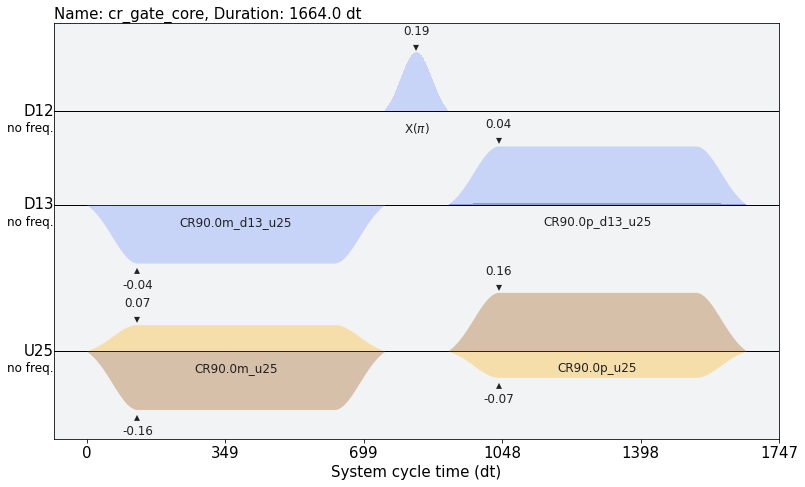

In [13]:
circuit, schedule = pulse_efficient_circuit(np.pi / 2., with_schedule=True)
schedule.draw(style=IQXDebugging())

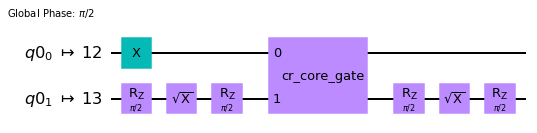

In [14]:
circuit = transpile(circuit, backend=backend, initial_layout=[control_qubit, target_qubit])
circuit.draw('mpl', idle_wires=False)

### Circuits to run

In [15]:
if 'pe' in experiments:
    circuit_lists['pe'] = []
    for phi_value in phi_values:
        circuits = process_tomography_circuits(pulse_efficient_circuit(phi_value), register)
        # Remove the barriers
        circuits = [remove_barriers(circuit) for circuit in circuits]
        # Transpile
        circuit_lists['pe'].append(transpile(circuits, backend=backend, initial_layout=[control_qubit, target_qubit]))
        
    circuit = circuit_lists['pe'][example_index[0]][example_index[1]]
    print(circuit.name)
    circuit.draw('mpl', idle_wires=False)

## Linearized $R_{ZZ}$

- First idea: Let GaussianSquare align itself with multiples of 16 by extending the tails. Calibration is for 2 sigma but having additional sigmas should not matter too much.

- Second idea: Define a pulse shape class that adds an internal delay to make the overall duration a multiple of 16 while driving only with 2 sigmas (See PaddedGaussianSquare in pulse_experiment_utilsß)  
  -> Did not work; qiskit sends pulse class names and parameter values rather than the actual waveform.

### Schedule generator

In [16]:
def make_cr_core(width, phi_label=0, cancel_width=None):
    target_duration = int(np.ceil((width + 2 * tail) / 16.) * 16)
    cr_pulse = pulse.GaussianSquare(duration=target_duration, amp=cr.amp, sigma=sigma, width=width, name='CR{}p_u{}'.format(phi_label, control_channel.index))
    cr_rotary_pulse = pulse.GaussianSquare(duration=target_duration, amp=crr.amp, sigma=sigma, width=width, name='CR{}p_d{}_u{}'.format(phi_label, target_drive_channel.index, control_channel.index))
    cr_echo = pulse.GaussianSquare(duration=target_duration, amp=-cr.amp, sigma=sigma, width=width, name='CR{}m_u{}'.format(phi_label, control_channel.index))
    cr_rotary_echo = pulse.GaussianSquare(duration=target_duration, amp=-crr.amp, sigma=sigma, width=width, name='CR{}m_d{}_u{}'.format(phi_label, target_drive_channel.index, control_channel.index))

#    target_duration = int(np.round(width + 2 * tail))
#    cr_pulse = PaddedGaussianSquare(pulse_duration=target_duration, amp=cr.amp, sigma=sigma, width=width)
#    cr_rotary_pulse = PaddedGaussianSquare(pulse_duration=target_duration, amp=crr.amp, sigma=sigma, width=width)
#    cr_echo = PaddedGaussianSquare(pulse_duration=target_duration, amp=-cr.amp, sigma=sigma, width=width)
#    cr_rotary_echo = PaddedGaussianSquare(pulse_duration=target_duration, amp=-crr.amp, sigma=sigma, width=width)

    if cancel_width is None:
        duration = 2 * tail
        cancel_pulse = pulse.Gaussian(duration=duration, amp=-cr.amp, sigma=sigma, name='CR{}p_u{}'.format(phi_label, control_channel.index))
        cancel_rotary_pulse = pulse.Gaussian(duration=duration, amp=-crr.amp, sigma=sigma, name='CR{}p_d{}_u{}'.format(phi_label, target_drive_channel.index, control_channel.index))
        cancel_echo = pulse.Gaussian(duration=duration, amp=cr.amp, sigma=sigma, name='CR{}m_u{}'.format(phi_label, control_channel.index))
        cancel_rotary_echo = pulse.Gaussian(duration=duration, amp=crr.amp, sigma=sigma, name='CR{}m_d{}_u{}'.format(phi_label, target_drive_channel.index, control_channel.index))
    else:
        duration = int(np.ceil((cancel_width + 2 * tail) / 16.) * 16)
        cancel_pulse = pulse.GaussianSquare(duration=duration, amp=-cr.amp, sigma=sigma, width=cancel_width, name='CR{}p_u{}'.format(phi_label, control_channel.index))
        cancel_rotary_pulse = pulse.GaussianSquare(duration=duration, amp=-crr.amp, sigma=sigma, width=cancel_width, name='CR{}p_d{}_u{}'.format(phi_label, target_drive_channel.index, control_channel.index))
        cancel_echo = pulse.GaussianSquare(duration=duration, amp=cr.amp, sigma=sigma, width=cancel_width, name='CR{}m_u{}'.format(phi_label, control_channel.index))
        cancel_rotary_echo = pulse.GaussianSquare(duration=duration, amp=crr.amp, sigma=sigma, width=cancel_width, name='CR{}m_d{}_u{}'.format(phi_label, target_drive_channel.index, control_channel.index))
        
    with pulse.build(backend=backend, default_alignment='sequential', name='cr_gate_core') as cr_core_sched:
        ## echo (without the first X on control)
        with pulse.align_left():
            pulse.play(cr_echo, control_channel)
            pulse.play(cancel_echo, control_channel)
            pulse.play(cr_rotary_echo, target_drive_channel)
            pulse.play(cancel_rotary_echo, target_drive_channel)

        pulse.play(control_x_pulse, control_drive_channel)

        ## forward
        with pulse.align_left():
            pulse.play(cr_pulse, control_channel)
            pulse.play(cancel_pulse, control_channel)
            pulse.play(cr_rotary_pulse, target_drive_channel)
            pulse.play(cancel_rotary_pulse, target_drive_channel)
            
    return cr_core_sched

### Calibration of the width parameter

In [17]:
need_calibration = False

if need_calibration:
    circuits = []
    for width in range(0, 2 * cr.width, 32):
        cr_core_sched = make_cr_core(width)

        cr_core_gate = Gate('cr_core_gate', 2, [])

        circuit = QuantumCircuit(2)
        circuit.x(0)
        circuit.append(cr_core_gate, (0, 1))
        circuit.measure_all()

        circuit.add_calibration('cr_core_gate', (control_qubit, target_qubit), cr_core_sched)

        circuits.append(circuit)

    circuits = transpile(circuits, backend=backend, initial_layout=[control_qubit, target_qubit])

    job = backend.run(circuits, shots=8192)
    print(job.job_id())

    job_monitor(job)
    result = job.result()

    x_values = np.arange(0, 2 * cr.width, 32)
    y_values = plot_counts(result, ['00', '01'], x=x_values)

    init_params = [np.pi / 900., 0.5, 0.5]
    fitparams, conv = scipy.optimize.curve_fit(lambda w, v, amp, offset: offset + amp * np.cos(w * v), x_values, y_values, init_params)

    print(fitparams)

    plt.scatter(x_values, y_values)
    plt.plot(x_values, fitparams[2] + fitparams[1] * np.cos(fitparams[0] * x_values))
    plt.show()

    phi_at_cr_width = fitparams[0] * cr.width
    print(phi_at_cr_width)

else:
    #phi_at_cr_width = 1.2295209130164757 # kawasaki (0, 1)
    phi_at_cr_width = 1.3050605260748116 # kawasaki (12, 13)

In [18]:
def linearized_circuit(phi_value, with_schedule=False, correction_params=None):
    if phi_value == 0.:
        circuit = QuantumCircuit(register)

        if with_schedule:
            return circuit, pulse.Schedule(name='cr_gate_core')
        else:
            return circuit

    width = phi_value / phi_at_cr_width * cr.width
#     if correction_params is None:
#         cancel_width = None
#     else:
#         cancel_width = (correction_params[0] * phi_value + correction_params[1]) / phi_at_cr_width * cr.width
#         if cancel_with < 0.:
#             width += cancel_width
#             cancel_width = None
        
#     cr_core_sched = make_cr_core(width, phi_label=int(np.round(phi_value / np.pi * 180.)), cancel_width=cancel_width)

    if correction_params is not None:
        width -= (correction_params[0] * phi_value + correction_params[1]) / phi_at_cr_width * cr.width
        
    cr_core_sched = make_cr_core(width, phi_label=int(np.round(phi_value / np.pi * 180.)))
            
    cr_core_gate = Gate('cr_core_gate', 2, [])
    
    circuit = QuantumCircuit(register)
    circuit.x(0)
    circuit.h(1)
    circuit.append(cr_core_gate, (0, 1))
    circuit.h(1)

    circuit.add_calibration('cr_core_gate', (control_qubit, target_qubit), cr_core_sched)
    
    if with_schedule:
        return circuit, cr_core_sched
    else:
        return circuit

### Sample schedule ($R_{ZX}(\pi/8)$ minus X) and circuit

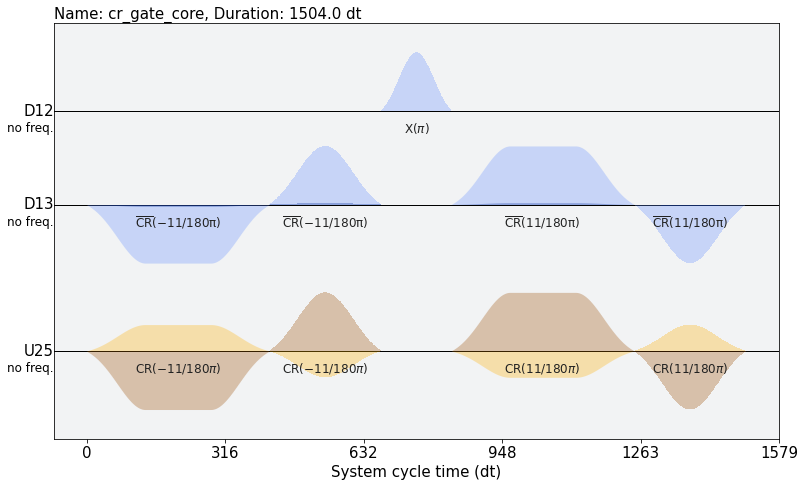

In [19]:
circuit, schedule = linearized_circuit(np.pi / 8., with_schedule=True)
schedule.draw()

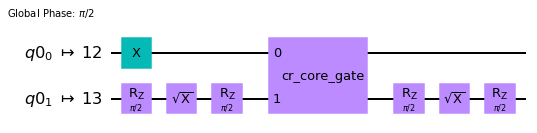

In [20]:
circuit = transpile(circuit, backend=backend, initial_layout=[control_qubit, target_qubit])
circuit.draw('mpl', idle_wires=False)

### Circuits to run

In [21]:
if 'li' in experiments:
    circuit_lists['li'] = []
    for phi_value in phi_values:
        circuits = process_tomography_circuits(linearized_circuit(phi_value), register)
        # Remove the barriers
        circuits = [remove_barriers(circuit) for circuit in circuits]
        # Transpile
        circuit_lists['li'].append(transpile(circuits, backend=backend, initial_layout=[control_qubit, target_qubit]))

    circuit = circuit_lists['li'][example_index[0]][example_index[1]]
    print(circuit.name)
    circuit.draw('mpl', idle_wires=False)

/usr/local/lib/python3.8/dist-packages/qiskit/ignis/verification/tomography/basis/circuits.py:465: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  prep += preparation(prep_label[j], prep_qubits[j])
/usr/local/lib/python3.8/dist-packages/qiskit/circuit/quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)
/usr/local/lib/python3.8/dist-packages/qiskit/ignis/verification/tomography/basis/circuits.py:478: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circ = prep + meas
/usr/local/lib/py

(('Zm', 'Xp'), ('Z', 'X'))


## Submit all jobs

In [22]:
for exp_name in experiments:
    with open('job_ids_oct04.txt'.format(exp_name), 'w') as out:
        for phi_value, circuits in zip(phi_values, circuit_lists[exp_name]):
            job = backend.run(circuits, shots=8192)
            print('{} {} {}'.format(exp_name, phi_value, job.job_id()))
            out.write('{} {} {}\n'.format(exp_name, phi_value, job.job_id()))

li 0.0 6156babd837ee46d42c22a3a
li 0.02617993877991494 6156bac0d35e280a74937fbd
li 0.05235987755982988 6156bac4204a02c02d983ec3
li 0.07853981633974483 6156bac7b98f0c8887521e20
li 0.10471975511965977 6156baca837ee40d51c22a3c
li 0.1308996938995747 6156bacc9f1b4a9595ff52c6
li 0.15707963267948966 6156bacec97866942308dc1d
li 0.18325957145940458 6156bad0fc7bdfca5d438efb
li 0.20943951023931953 6156bad3da98d55e832b66af
li 0.23561944901923448 6156bad69f1b4af89eff52c7
li 0.2617993877991494 6156bad8d35e283bd6937fbe
li 0.28797932657906433 6156badbb98f0c56b8521e21
li 0.3141592653589793 6156badec978666ae908dc1e
li 0.34033920413889424 6156bae09f1b4a09b1ff52c9
li 0.36651914291880916 6156bae2b98f0c77dc521e22
li 0.39269908169872414 6156bae5b98f0cd1e9521e23
li 0.41887902047863906 6156bae7837ee458ddc22a3d
li 0.445058959258554 6156bae9204a024430983ec4
li 0.47123889803846897 6156baeb20df54ec775e1790
li 0.4974188368183839 6156baedc97866ea2208dc20
li 0.5235987755982988 6156baefb98f0cfb9a521e24
li 0.5720801437

## Additional jobs for measurement error mitigation

In [23]:
need_error_mitigation = False

if need_error_mitigation:
    circuits = []

    circuit = QuantumCircuit(2)
    circuit.measure_all()
    for ic in range(16):
        circuit.name = '00_{}'.format(ic)
        circuits.append(circuit)

    circuit = QuantumCircuit(2)
    circuit.x(0)
    circuit.measure_all()
    for ic in range(16):
        circuit.name = '01_{}'.format(ic)
        circuits.append(circuit)

    circuit = QuantumCircuit(2)
    circuit.x(1)
    circuit.measure_all()
    for ic in range(16):
        circuit.name = '10_{}'.format(ic)
        circuits.append(circuit)

    circuit = QuantumCircuit(2)
    circuit.x(0)
    circuit.x(1)
    circuit.measure_all()
    for _ in range(16):
        circuit.name = '11_{}'.format(ic)
        circuits.append(circuit)

    with open('job_ids_sep21_mitigation.txt', 'w') as out:
        job = backend.run(circuits, shots=8192)
        print(job.job_id())
        out.write(job.job_id() + '\n')